## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

In [56]:
import string
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from IPython.display import clear_output

%matplotlib inline

time: 412 ms


In [9]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

time: 13.1 ms


In [10]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

time: 11.5 ms


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [12]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(map(str.lower, text))
# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!
time: 50.3 ms


Put all the characters, that you've seen in the text, into variable `tokens`.

In [13]:
tokens = sorted(set(text))

time: 10.6 ms


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [14]:
# dict <index>:<char>
# Your great code here
idx_to_token = dict(enumerate(tokens))

# dict <char>:<index>
# Your great code here
token_to_idx = dict(map(reversed, idx_to_token.items()))

time: 11.4 ms


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [37]:
def to_matrix(names, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_idx[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

time: 17.9 ms


In [98]:
class MyModel(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=16, rnn_num_units=64, RNNCellClass=nn.RNNCell):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn_cell = RNNCellClass(emb_size, rnn_num_units)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.emb(x)
        
        # rnn step
        h_next = self.rnn_cell(x_emb, h_prev)
        logits = self.hid_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

time: 19.8 ms


In [99]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

time: 18.7 ms


In [100]:
texts = text.split('\n')

time: 19.6 ms


In [101]:
char_rnn = MyModel(RNNCellClass=nn.RNNCell)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

time: 18.5 ms


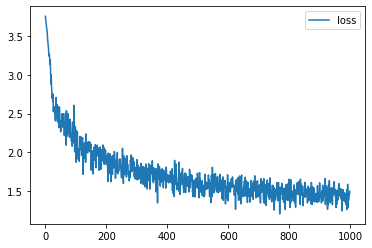

time: 1min 43s


In [102]:
batch_size = 32
num_tokens = len(tokens)

for i in range(1000):
    first_line_idxs = np.random.randint(0, len(texts), size=batch_size)
    texts_batch = [
        '\n'.join(texts[i:(i + 4)]) 
        for i in first_line_idxs
    ]
    max_len = np.max(list(map(len, texts_batch)))
    batch_ix = to_matrix(texts_batch, max_len=max_len)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:]# YOUR CODE HERE

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    ) # YOUR CODE HERE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    # YOUR CODE HERE
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Plot the loss function (axis X: number of epochs, axis Y: loss function).

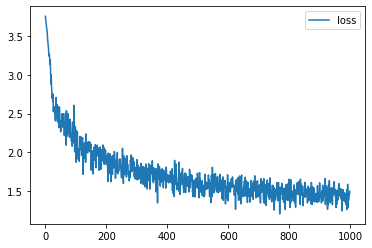

time: 253 ms


In [103]:
plt.plot(history, label='loss')
plt.legend()
plt.show()

In [104]:
MAX_LENGTH = int(np.median(list(map(len, texts)))*4)
print(MAX_LENGTH)

176
time: 20.9 ms


In [107]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
#         print(x_sequence.shape, x_sequence[:, -1].shape, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
#         print(x_sequence.shape, x_sequence, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
#         print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
#         print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

time: 20.7 ms


In [108]:
# An example of generated text.
print(generate_sample(char_rnn, temperature=1.0))

    whiy wactby seefs,
  the i doiges forl hamss acwern be sarid, o herrse are memh fiining, hae heart,
  anow ing i i my cead?
  my love etere will ties vich whis thyse,
  nor
time: 66.4 ms


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [111]:
a = nn.LSTMCell(10, 5)
a()

time: 18.1 ms


In [112]:
class MyLSTMModel(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn_cell = nn.LSTMCell(emb_size, rnn_num_units)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.emb(x)
        
        # rnn step
        h_next = self.rnn_cell(x_emb, h_prev)
        logits = self.hid_to_logits(h_next[0])
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return (
            torch.zeros(batch_size, self.num_units, requires_grad=True), 
            torch.zeros(batch_size, self.num_units, requires_grad=True)
        )

time: 19.8 ms


In [113]:
char_rnn = MyLSTMModel()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

time: 18.7 ms


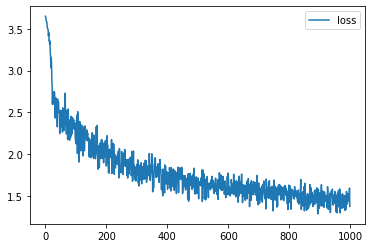

time: 2min 38s


In [114]:
batch_size = 32
num_tokens = len(tokens)

for i in range(1000):
    first_line_idxs = np.random.randint(0, len(texts), size=batch_size)
    texts_batch = [
        '\n'.join(texts[i:(i + 4)]) 
        for i in first_line_idxs
    ]
    max_len = np.max(list(map(len, texts_batch)))
    batch_ix = to_matrix(texts_batch, max_len=max_len)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:]# YOUR CODE HERE

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    ) # YOUR CODE HERE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    # YOUR CODE HERE
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [132]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"temp={t}:\n")
    print(generate_sample(char_rnn, temperature=t))
    print('='*110 + '\n')

temp=0.1:

                                                                                                                                                                                

temp=0.2:

                                                                                                                                                                                

temp=0.5:

  the is the colle shand the mase so menge
  and the in weant my of rowls in my mise.

  sout the for thee may the of the dorle see.
  my love my the stein and me the beare and

temp=1.0:

  maant tietug, to my mt sete:
  fith'n notily of hath aon chas he, bume'd,
  whepest: thou in sizs that in tofe this socant,
  wrec; butting betorive buving mi eper-u  feantin

temp=2.0:

 d in   i xyen?om.s'u mu heor,n( bub ;: deet. epvoun thougurys,;
  urn'mesiaathid yay hush:
  shaxnkur dacf'; peeld uuestyain.rs ifosfe?idy.
tgel woutb:  hoiwi. .nfe bingmes.-


time: 285 ms


Видно, что при самых маленьких температурах генерируется текст из самого частого токена(пробел). Если чуть увеличить температуру, то текст уже состоит из наиболее частых слов и последовательностей букв + начинает соблюдаться структура сонетов. С температурой = 2 текст состоит из случайных символов, так как распределение ближе к равномерному.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [133]:
save_path = './model.pth'
torch.save(char_rnn.state_dict(), save_path)

time: 20.4 ms


In [134]:
loaded_char_rnn = MyLSTMModel()
loaded_char_rnn.load_state_dict(torch.load(save_path))

<All keys matched successfully>

time: 20.6 ms


In [135]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"temp={t}:\n")
    print(generate_sample(loaded_char_rnn, temperature=t))
    print('='*110 + '\n')

temp=0.1:

                                                                                                                                                                                

temp=0.2:

                                                                                                                                                                                

temp=0.5:

  day the ald be famen thy guls the theater dead and dearn's bed                                                                                                                

temp=1.0:

  yfare, wiln bade, a ne sertyore to fiting t sthet meinb
  and and nut, that upluspe thy iw be thiy war wove insto
  finelles bav,                                             

temp=2.0:

 wht onk, ,-u lyel hat., -cam)'
  utlos rieq.a fe nr.r?;
  swhoay'dt inh-thy shopmswh.;
  weudie!t wleit erwnobeses o, wontiwe.
-;y moxxvstemy;
 deaeink     s  thesiefron'se;n:

time: 272 ms


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)